In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest,f_classif 

from sklearn.linear_model import SGDRegressor

# Loading the dataset

In [3]:
X = pd.read_csv('train_X.csv')
y = pd.read_csv('train_y.csv')
X_true = pd.read_csv('test_X.csv')
y_example = pd.read_csv('random_sample.csv')

# See the EDA file for details on the preprocessing & strategy

In [4]:
mask = (X['GROUP_ID'] == 2)
X_groupe2 = X[mask]
X_groupe3 = X[~mask]

mask = ( X_true['GROUP_ID']==2 ) #same for X_true
X_true2 = X_true[mask]
X_true3 = X_true[~mask]

y2 = y['PRODUCTION_GROUP_2'] #splitting the target for each group
y3 = y['PRODUCTION_GROUP_3']

# ##################FIRST : ASSETS OF GROUP 2#####################


In [5]:
# boolean indexing, storing hours (type 3 only) in a numpy array : A2

def preproc1(X):

    mask = ( X['MEASURE_TYPE']==3 ) 
    X = X[mask]
    

    A2 = np.zeros((104,27))
    
    for i in range(104):
        for j in range(27):
            mask = ( X['ASSET_ID'] == j+1 ) & ( X['MEASURE_WEEK'] == i+1 )
            A2[i,j] = X['MEASURE_VALUE'][mask].sum()

    return(A2)

A2 = preproc1(X_groupe2)
print("A2 is a matrix of size : ", A2.shape)

########################################################################################################
# then we delete all values beyond a threshold (found empirically)  -> problem in the asset means no production at all

medianes = np.median(A2,axis=0)
threshold = 1.8 #empirical
mask_threshold = ( A2 > medianes*threshold ) 
A2[ mask_threshold ] = 0



A2 is a matrix of size :  (104, 27)


# Splitting train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split( A2, y2, test_size=0.3, random_state=0)



def best_value_alpha(X_train, X_test, y_train, y_test):  # looking for the best regularization value
    
    list_alpha =[0.01, 0.1, 0.3, 1, 3, 10, 100, 1000, 10000]
    L=[]
    best_regul = 0.01
    best_error = 10e10
    
    for val in list_alpha :
        
        model = make_pipeline( StandardScaler(), SGDRegressor(random_state=0, alpha=val) )
        model.fit(X_train, y_train)
        ypred = model.predict( X_test )
        error_current = mean_squared_error(ypred, y_test, squared=False)
        
        if error_current < best_error :
            best_regul = val
            best_error = error_current
        
    return best_regul
    
    
best_alpha = best_value_alpha(X_train, X_test, y_train, y_test)
print("best alpha=", best_alpha)




best alpha= 3


# Learning curves

Learning curves:


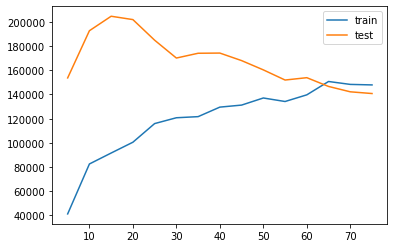

In [25]:
def curves(X_train, X_test, y_train, y_test):
    
    sizes = range(5,80,5)
    L_error_test=[]
    L_error_train=[]
    
    for size in sizes:
        
        xtr = X_train[0:size,:]
        ytr = y_train[0:size]
        
        model = make_pipeline( StandardScaler(), SGDRegressor(random_state=0,alpha=1) )
        model.fit(xtr, ytr)
        
        ypred_tr = model.predict(xtr)
        L_error_train.append( mean_squared_error(ypred_tr, ytr, squared=False) )
        
        ypred_test = model.predict(X_test)
        L_error_test.append(mean_squared_error( ypred_test, y_test, squared=False) )
        
    print("Learning curves:")  
    plt.figure()
    plt.plot(sizes, L_error_train, label="train")
    plt.plot(sizes, L_error_test, label="test") 
    plt.legend()
    
    
curves(X_train, X_test, y_train, y_test)

# FINAL PREDICTION FOR GROUP 2

In [29]:
# same preprocessing for X_true

def preproc2(X):

    mask = ( X['MEASURE_TYPE'] ==3 )
    X = X[mask]
   
    A = np.zeros((46,27))
    
    for i in range(46):
        for j in range(27):
            mask = ( X['ASSET_ID'] == j+1 ) & ( X['SAMPLE_ID'] == 105+i )
            A[i,j] = X['MEASURE_VALUE'][mask].sum()  
            
    return(A)



A2_true = preproc2( X_true2 )
print("A2_true size is :",A2_true.shape)

########################################################################################################
# same : delete the pikes

mask= ( A2_true > medianes*threshold )
A2_true[mask] = 0


A2_true size is : (46, 27)


In [32]:
model = make_pipeline( StandardScaler(), SGDRegressor(random_state=0, alpha = best_alpha) )
model.fit(A2,y2)
ypred_final_group2= model.predict(A2_true)

print(ypred_final_group2.shape)
ypred_final_group2[0:5]

(46,)


array([3852225.54180587, 3769307.2495868 , 3831290.32395676,
       3944719.59654164, 3689363.94929525])

# ##############SAME FOR ASSETS OF GROUP 3#####################

In [34]:
# Storing the hours of work (type3 only) in a numpy matrix : A3

def preproc3(X): 

    mask = ( X['MEASURE_TYPE'] == 3 )
    X = X[mask]
    
    A3 = np.zeros((104,56))
    
    for i in range(104):
        for j in range(56):
            mask = ( X['ASSET_ID'] == j+28 ) & ( X['MEASURE_WEEK'] == i+1 )
            A3[i,j] = X['MEASURE_VALUE'][mask].sum()
    return(A3)

A3 = preproc3( X_groupe3 )
print("matrix A3 is size : ",A3.shape)

########################################################################################################
# same : delete the pikes

medianes = np.median(A3, axis=0)
threshold = 2.1 #empirical
mask = (A3 > medianes*threshold)
A3[mask] = 0

matrix A3 is size :  (104, 56)


# Regularization and learning curves

In [39]:
X_train, X_test, y_train, y_test = train_test_split( A3, y3, test_size=0.3, random_state=0)

def best_value_alpha(X_train, X_test, y_train, y_test):  # looking for the best regularization value
    
    list_alpha =[0.01, 0.1, 0.3, 1, 3, 10, 100, 1000, 10000]
    L=[]
    best_regul = 0.01
    best_error = 10e10
    
    for val in list_alpha :
        
        model = make_pipeline( StandardScaler(), SGDRegressor(random_state=0, alpha=val) )
        model.fit(X_train, y_train)
        ypred = model.predict( X_test )
        error_current = mean_squared_error(ypred, y_test, squared=False)
        
        if error_current < best_error :
            best_regul = val
            best_error = error_current
        
    return best_regul
    
    
best_alpha = best_value_alpha(X_train, X_test, y_train, y_test)
print("best alpha=", best_alpha)


best alpha= 1


Learning curves:


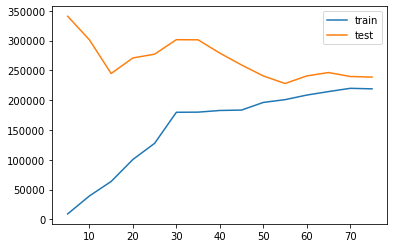

In [42]:
def curves(X_train, X_test, y_train, y_test):
    
    sizes = range(5,80,5)
    L_error_test=[]
    L_error_train=[]
    
    for size in sizes:
        
        xtr = X_train[0:size,:]
        ytr = y_train[0:size]
        
        model = make_pipeline( StandardScaler(), SGDRegressor(random_state=0,alpha=1) )
        model.fit(xtr, ytr)
        
        ypred_tr = model.predict(xtr)
        L_error_train.append( mean_squared_error(ypred_tr, ytr, squared=False) )
        
        ypred_test = model.predict(X_test)
        L_error_test.append(mean_squared_error( ypred_test, y_test, squared=False) )
        
    print("Learning curves:")  
    plt.figure()
    plt.plot(sizes, L_error_train, label="train")
    plt.plot(sizes, L_error_test, label="test") 
    plt.legend()
    
    
curves(X_train, X_test, y_train, y_test)

# Same preprocessing for X_true, and prediction

In [35]:
# Same for X_true

def preproc4(X): 

    mask = ( X['MEASURE_TYPE'] == 3 )
    X = X[mask]
   
    A=np.zeros((46,56))
   
    for i in range(46):
        for j in range(56):
            mask = ( X['ASSET_ID']==28+j ) & ( X['SAMPLE_ID']==105+i )
            A[i,j] = X['MEASURE_VALUE'][mask].sum()
    
    return(A)



A3_true = preproc4(X_true3)
print("A3_true is size : ", A3_true.shape)

# delete pikes

mask2 = ( A3_true > medianes*threshold )
A3_true[mask2] = 0

A3_true is size :  (46, 56)


In [43]:
model = make_pipeline( StandardScaler(), SGDRegressor( random_state=0, alpha=best_alpha) )
model.fit(A3,y3)

ypred_final_group3 = model.predict(A3_true)

print(ypred_final_group3.shape)
ypred_final_group3[0:5]

(46,)


array([9361205.87705467, 9249256.78672033, 9628603.68625237,
       9169516.12746263, 8851873.81935316])

# Final prediction for the challenge.


In [45]:
y_example['PRODUCTION_GROUP_2'] = ypred_final_group2
y_example['PRODUCTION_GROUP_3'] = ypred_final_group3
y_example.to_csv('prediction_pierre.csv' ,index=False)
y_example

,SAMPLE_ID,PRODUCTION_GROUP_2,PRODUCTION_GROUP_3
0,105,3.852226e+06,9.361206e+06
1,106,3.769307e+06,9.249257e+06
2,107,3.831290e+06,9.628604e+06
3,108,3.944720e+06,9.169516e+06
4,109,3.689364e+06,8.851874e+06
5,110,4.006076e+06,9.449874e+06
6,111,3.700315e+06,9.168325e+06
7,112,3.552932e+06,8.555380e+06
8,113,3.755154e+06,9.105396e+06
9,114,3.883544e+06,9.330229e+06


# What to try next? 

Decision tree regressor, 

random forrest regressor, 

hours of type 1, 2 and 4, 

etc...

# ########### PERSONNAL NOTES : DO NOT READ ###############"

In [23]:
#détermination du meilleur seuil pour arraser les pics (fait en preprocess)

def meilleur_seuil(medianes, X_train, X_test, y_train, y_test): 
    seuils=np.linspace(4,1,100)
    L=[]
    
    for coef in seuils:
        mask1=X_train>medianes*coef  
        X_train[mask1]=0
        
        mask2=X_test>medianes*coef
        X_test[mask2]=0

        model=make_pipeline(StandardScaler(),SGDRegressor(random_state=0,alpha=10))
        model.fit(X_train,y_train)
        ypred=model.predict(X_test)

        L.append(mean_squared_error(ypred,y_test))
    print("courbe pour le meilleur coef d'arrasement:")
    plt.plot(seuils,L)
    


# essai d'expansion polynomiale pour contrer le bias (échec)

In [6]:
#prévision : on entraine sur A2. On prédit sur A2_true.

model=make_pipeline(PolynomialFeatures(2),StandardScaler(),SGDRegressor(random_state=0,alpha=best_regul))
model.fit(A2,y2)

ypred_finale2= model.predict(A2_true)

print(ypred_finale2.shape)
ypred_finale2[0:5]

(46,)


array([3927217.97238462, 3716471.1411272 , 3869620.01059734,
       4098369.42477521, 3567117.59164064])

In [10]:
#prévision : on entraine sur A3. On prédit sur A3_true.

model=make_pipeline(PolynomialFeatures(2),StandardScaler(),SGDRegressor(random_state=0,alpha=best_regul))
model.fit(A3,y3)

ypred_finale3= model.predict(A3_true)

print(ypred_finale3.shape)
ypred_finale3[0:5]

(46,)


array([-3.19799467e+12, -4.46649915e+12, -8.71230565e+11, -3.29392135e+12,
       -1.25714627e+12])